In [1]:
import torch # 기본 파이토치 기능
import torch.nn as nn # nn 모듈 기능
import torch.nn.functional as F # 기본 신경망 함수
import torch.optim as optim # 최적화
from torchvision import datasets, transforms # 데이터셋 처리
import matplotlib.pyplot as plt # 데이터 시각화
import optuna # 하이퍼파라미터 튜닝 라이브러리

# ========================
# 1. 데이터 로드 및 전처리
# ========================
def load_data(batch_size=64):
    transform_train = transforms.Compose([
        transforms.RandomRotation(10), # 이미지를 최대 ±10도까지 무작위로 회전
        # 이미지를 가로, 세로 ±10% 범위 내에서 무작위로 이동
        # degree를 0으로 설정했으므로, Rotation없이 가로 세로 이동만 한다.
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # 평균 0.5, 표준편차 0.5로 정규화
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) # 평균 0.5, 표준편차 0.5로 정규화
    ])
    # 학습 데이터 셋 다운로드 60000개 / 저장 위치는 root의 data 폴더 
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform_train, download=True)
    # 테스트 데이터 셋 다운로드 10000개 / 저장 위치는 root의 data 폴더 
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform_test, download=True)
    
    # 6만개 샘플들을 64 배치 사이즈 설정 및 셔플 설정하여 랜덤하게 train_loader에 담는다. 
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    # 1만개 샘플들을 64 배치 사이즈 설정 및 셔플 미설정하여 순서대로 test_loader에 담는다. 
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

### Data loading & preprocessing

#### Data augmentation (데이터 증강) 처리 추가
- Rotation, Affine Transformation을 통해 데이터 증강하여 *overfitting* 방지, *robustness* 증대, *Generalization* 성능을 기대할 수 있다.

In [2]:
class LeNet5(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(LeNet5, self).__init__()
        # C1: 합성곱 층 (입력: 1x32x32 → 출력: 6x28x28)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
        # S2: 평균 풀링 층 (출력: 6x14x14)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        # C3: 합성곱 층 (출력: 16x10x10)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        # S4: 평균 풀링 층 (출력: 16x5x5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        # C5: 합성곱 층 (출력: 120x1x1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)
        # F6: 완전 연결층 (출력: 84)
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        # Output: 완전 연결층 (출력: 10)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # 입력 크기: (batch_size, 1, 28, 28)
        # LeNet-5는 32x32 입력을 기대하지만, MNIST는 28x28이므로 패딩을 추가
        x = F.pad(x, (2, 2, 2, 2))  # 패딩 추가하여 32x32로 변환
        x = F.relu(self.conv1(x))    # C1
        x = self.pool1(x)            # S2
        x = F.relu(self.conv2(x))    # C3
        x = self.pool2(x)            # S4
        x = F.relu(self.conv3(x))    # C5 120x1x1 
        x = x.view(x.size(0), -1)    # Flatten 64x120의 2차원 텐서로 변경
        x = F.relu(self.fc1(x))      # F6
        x = self.fc2(x)              # Output
        return x

### LeNet5 Modeling
**1 - 1st conv : 커널 사이즈 5x5**
- 입력 : 1채널의 32x32 이미지
- 출력 : 6채널의 28x28 이미지
- *stride=1*은 컨볼루션 연산 시 건너 뛰는 간격으로, 보통 모든 픽셀에 대해 컨볼루션 수행하므로 1로 설정함

**RELU 함수 적용1**

**2 - 1st pool : 커널 사이즈 2x2**
- 입력 : 6채널의 28x28 이미지
- 출력 : 6채널의 14x14 이미지

**3 - 2nd conv : 커널 사이즈 5x5**
- 입력 : 6채널의 14x14 이미지 
- 출력 : 16채널의 10x10 이미지 (padding 없이 5x5 커널을 사용했으므로 상하좌우로 2라인씩 줄어들어 10x10이 됨)
-> 6x14x14에 *16개의 5x5 커널*과 컨볼루션 연산 하면 16x10x10이 됨

**RELU 함수 적용2**

**4 - 2nd pool : 커널 사이즈 2x2**
- 입력 : 16채널의 10x10 이미지
- 출력 : 16채널의 5x5 이미지

**5 - 3rd conv : 커널 사이즈 5x5**
- 입력 : 16채널의 5x5 이미지 
- 출력 : 120채널의 1x1 이미지

**RELU 함수 적용3**

**conv 결과에 Flatten 처리**

**6 - FCL1**
- 입력 : 120 차원 벡터 [[x1, x2, x3, ... ,x120]]
- 출력 : 84 차원 벡터 [[x1, x2, x3, ... ,x84]]

**RELU 함수 적용4**

**7 - FCL2**
- 입력 : 84 차원 벡터 [[x1, x2, x3, ... ,x84]]
- 출력 : 10 차원 벡터 [[x1, x2, x3, ... ,x10]] **-> logit**

---
#### 멀티 채널에서의 컨볼루션 연산 
입력: 32×32x3
필터: 3x5×5, 총 6개.
출력: 28x28x6
하나의 필터는 입력 데이터의 모든 채널(3채널)에 대해 합성곱 연산을 수행한 후, 결과를 합산하여 하나의 피처맵 생성.
6개의 필터가 독립적으로 작동하여 총 6개의 피처맵 생성. 

---
#### Flatten 처리
- Fully Connected Layer를 통과하기 전에 Flatten 처리를 함
- x.view(x.size(0), -1)
- x는 120x1x1의 3차원 텐서이고, x.size(0)는 배치 사이즈를 의미 64
- 64x120 크기의 2차원 텐서로 평탄화 시킴

In [3]:
# ========================
# 3. 학습 함수
# ========================
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device) 
    # 모델의 (정적 초기화 레이어의 파라미터 및 버퍼) cpu 디바이스로 보내짐 (근데 원래 cpu에서 생성되었음)
    # 모델이 원래 cpu에서 생성되었으므로, 사실 위치를 변경하지 않으나, 코드의 일관성, 호환성, 안정성, 명확성을 위하여 코드로 명시하는 것이 좋음
    # 추후 GPU에서 학습 시 모델을 GPU로 보내기 위해 값을 변경해주어야 함 

    for epoch in range(num_epochs):
        model.train() # 모델을 training mode로 전환
        total_loss = 0 # loss 값 초기화 
        for images, labels in train_loader: # 훈련 셋의 배치 단위로 images, lables 반환이 반복됨 
            images, labels = images.to(device), labels.to(device) # 데이터x도 cpu 디바이스로 보냄. (마찬가지로 GPU로 변경 시 GPU로 보내짐)

            # Forward pass
            outputs = model(images) # images만 모델에 입력
            loss = criterion(outputs, labels) # 모델 출력 결과와 정답 비교하여 loss 계산 

            # Backward pass and optimization
            optimizer.zero_grad() # 옵티마이저의 기울기 초기화 
            loss.backward() # 손실에 대한 기울기 계산 
            optimizer.step() # 옵티마이저의 최적화 단계 수행

            total_loss += loss.item() # 손실 누적 값 계산 
        
        # 한 Epoch에서의 평균 손실 출력
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

In [4]:
# ========================
# 4. 평가 함수
# ========================
def evaluate_model_accuracy(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # output = 64 x 10 (배치 사이즈 x 10차원 행벡터)
            _, predicted = torch.max(outputs, 1) # torch.max의 반환 값은 튜플 : 각 행의 최대값, 각 행의 최대값 인덱스
            total += labels.size(0) # 현재 샘플 갯수 (배치 단위로 더함 64+64+ ... )
            correct += (predicted == labels).sum().item() # (predicted == labels)는 Boolean 값이고, 이것 또한 batch size 단위로 계산됨. 즉 64 차원의 Boolean값이 저장된 텐서임

    accuracy = 100 * correct / total
    # print(f'Accuracy on test set: {accuracy:.2f}%')

In [5]:
# ========================
# 5. 예측 시각화
# ========================
def visualize_predictions(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    data_iter = iter(test_loader) # test_loader를 iterator로 변환 (데이터를 직접 순회하기 위해)
    images, labels = next(data_iter) # 이터레이터를 생성하고 바로 next()를 호출하면 맨 처음 값부터 가져 옴
    images, labels = images[:5].to(device), labels[:5].to(device) # 처음부터 5까지 이미지랑 레이블을 디바이스로 보냄

    # 모델 예측
    outputs = model(images) # 모델에 이미지를 입력하고 아웃풋을 저장
    _, preds = torch.max(outputs, 1) # 예측값을 preds 변수에 저장 

    # 시각화
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for idx, ax in enumerate(axes):
        ax.imshow(images[idx].cpu().squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[idx].item()}\nPred: {preds[idx].item()}')
        ax.axis('off')
    plt.show()

In [7]:
# ========================
# 6. Optuna를 사용한 하이퍼파라미터 튜닝 함수
# ========================
def objective(trial):
    # 하이퍼파라미터 제안
    # 2/3번째 매개변수 값 : 하이퍼파라미터 튜닝을 위해 Optuna가 탐색할 하이퍼파라미터의 탐색 공간(search space)을 정의하는 값
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2) # 추후 suggest_float으로 변경 필요
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5) # 추후 suggest_float으로 변경 필요
    num_epochs = trial.suggest_int('num_epochs', 5, 20)
    
    # 데이터 로드
    train_loader, test_loader = load_data(batch_size)
    
    # 모델 초기화
    model = LeNet5(dropout_rate=dropout_rate)
    
    # 손실 함수 및 최적화 알고리즘
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 모델 학습
    train_model(model, train_loader, criterion, optimizer, num_epochs)
    
    # 모델 평가
    accuracy = evaluate_model_accuracy(model, test_loader)
    
    return accuracy

[I 2024-12-27 11:27:06,523] A new study created in memory with name: no-name-b7cdc490-27db-4553-8d13-a59df7b0f708
C:\Users\Admin\AppData\Local\Temp\ipykernel_10984\1165575615.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\Admin\AppData\Local\Temp\ipykernel_10984\1165575615.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


Epoch [1/7], Loss: 2.2338
Epoch [2/7], Loss: 1.6289
Epoch [3/7], Loss: 1.2569
Epoch [4/7], Loss: 1.1172
Epoch [5/7], Loss: 1.0190
Epoch [6/7], Loss: 0.9239
Epoch [7/7], Loss: 0.8319


[I 2024-12-27 11:30:06,381] Trial 0 finished with value: 88.52 and parameters: {'learning_rate': 4.3523031064467625e-05, 'batch_size': 256, 'dropout_rate': 0.39460903934704766, 'num_epochs': 7}. Best is trial 0 with value: 88.52.


Epoch [1/10], Loss: 1.4594
Epoch [2/10], Loss: 0.7553
Epoch [3/10], Loss: 0.4828
Epoch [4/10], Loss: 0.3433
Epoch [5/10], Loss: 0.2737
Epoch [6/10], Loss: 0.2304
Epoch [7/10], Loss: 0.2078
Epoch [8/10], Loss: 0.1851
Epoch [9/10], Loss: 0.1749
Epoch [10/10], Loss: 0.1654


[I 2024-12-27 11:34:40,020] Trial 1 finished with value: 97.62 and parameters: {'learning_rate': 0.0001517854182516807, 'batch_size': 128, 'dropout_rate': 0.2291306022294895, 'num_epochs': 10}. Best is trial 1 with value: 97.62.


Epoch [1/15], Loss: 2.3008
Epoch [2/15], Loss: 2.2324
Epoch [3/15], Loss: 1.9735
Epoch [4/15], Loss: 1.6458
Epoch [5/15], Loss: 1.4287
Epoch [6/15], Loss: 1.2982
Epoch [7/15], Loss: 1.2176
Epoch [8/15], Loss: 1.1519
Epoch [9/15], Loss: 1.1028
Epoch [10/15], Loss: 1.0605
Epoch [11/15], Loss: 1.0219
Epoch [12/15], Loss: 0.9778
Epoch [13/15], Loss: 0.9360
Epoch [14/15], Loss: 0.8980
Epoch [15/15], Loss: 0.8594


[I 2024-12-27 11:41:44,248] Trial 2 finished with value: 88.72 and parameters: {'learning_rate': 1.2055237638131643e-05, 'batch_size': 128, 'dropout_rate': 0.44837154022584036, 'num_epochs': 15}. Best is trial 1 with value: 97.62.


Epoch [1/8], Loss: 0.5013
Epoch [2/8], Loss: 0.1413
Epoch [3/8], Loss: 0.1058
Epoch [4/8], Loss: 0.0910
Epoch [5/8], Loss: 0.0784
Epoch [6/8], Loss: 0.0705
Epoch [7/8], Loss: 0.0632
Epoch [8/8], Loss: 0.0613


[I 2024-12-27 11:44:53,994] Trial 3 finished with value: 99.2 and parameters: {'learning_rate': 0.005179258795539069, 'batch_size': 256, 'dropout_rate': 0.2497288713272615, 'num_epochs': 8}. Best is trial 3 with value: 99.2.


Epoch [1/10], Loss: 0.6506
Epoch [2/10], Loss: 0.1726
Epoch [3/10], Loss: 0.1278
Epoch [4/10], Loss: 0.1051
Epoch [5/10], Loss: 0.0880
Epoch [6/10], Loss: 0.0833
Epoch [7/10], Loss: 0.0734
Epoch [8/10], Loss: 0.0704
Epoch [9/10], Loss: 0.0617
Epoch [10/10], Loss: 0.0621


[I 2024-12-27 11:49:08,770] Trial 4 finished with value: 98.91 and parameters: {'learning_rate': 0.002845216908360668, 'batch_size': 256, 'dropout_rate': 0.4912760211258839, 'num_epochs': 10}. Best is trial 3 with value: 99.2.


Epoch [1/12], Loss: 0.2875
Epoch [2/12], Loss: 0.1301
Epoch [3/12], Loss: 0.1083
Epoch [4/12], Loss: 0.1006
Epoch [5/12], Loss: 0.0999
Epoch [6/12], Loss: 0.0998
Epoch [7/12], Loss: 0.0934
Epoch [8/12], Loss: 0.0948
Epoch [9/12], Loss: 0.0974
Epoch [10/12], Loss: 0.0891
Epoch [11/12], Loss: 0.0914
Epoch [12/12], Loss: 0.0870


[I 2024-12-27 11:54:34,616] Trial 5 finished with value: 98.58 and parameters: {'learning_rate': 0.009517355632102839, 'batch_size': 64, 'dropout_rate': 0.3080505307547531, 'num_epochs': 12}. Best is trial 3 with value: 99.2.


Epoch [1/12], Loss: 1.4916
Epoch [2/12], Loss: 0.6907
Epoch [3/12], Loss: 0.3520
Epoch [4/12], Loss: 0.2597
Epoch [5/12], Loss: 0.2129
Epoch [6/12], Loss: 0.1896
Epoch [7/12], Loss: 0.1693
Epoch [8/12], Loss: 0.1557
Epoch [9/12], Loss: 0.1469
Epoch [10/12], Loss: 0.1368
Epoch [11/12], Loss: 0.1300
Epoch [12/12], Loss: 0.1244


[I 2024-12-27 11:59:33,554] Trial 6 finished with value: 98.03 and parameters: {'learning_rate': 0.00030893735477430164, 'batch_size': 256, 'dropout_rate': 0.4543683086111921, 'num_epochs': 12}. Best is trial 3 with value: 99.2.


Epoch [1/7], Loss: 1.9925
Epoch [2/7], Loss: 1.2261
Epoch [3/7], Loss: 1.0557
Epoch [4/7], Loss: 0.9303
Epoch [5/7], Loss: 0.8030
Epoch [6/7], Loss: 0.6752
Epoch [7/7], Loss: 0.5621


[I 2024-12-27 12:02:17,196] Trial 7 finished with value: 92.15 and parameters: {'learning_rate': 9.283242308523981e-05, 'batch_size': 256, 'dropout_rate': 0.30120597524102366, 'num_epochs': 7}. Best is trial 3 with value: 99.2.


Epoch [1/16], Loss: 1.9973
Epoch [2/16], Loss: 1.2823
Epoch [3/16], Loss: 1.1315
Epoch [4/16], Loss: 1.0426
Epoch [5/16], Loss: 0.9436
Epoch [6/16], Loss: 0.8450
Epoch [7/16], Loss: 0.7268
Epoch [8/16], Loss: 0.6155
Epoch [9/16], Loss: 0.5238
Epoch [10/16], Loss: 0.4570
Epoch [11/16], Loss: 0.4091
Epoch [12/16], Loss: 0.3700
Epoch [13/16], Loss: 0.3421
Epoch [14/16], Loss: 0.3177
Epoch [15/16], Loss: 0.3032
Epoch [16/16], Loss: 0.2834


[I 2024-12-27 12:08:55,117] Trial 8 finished with value: 96.02 and parameters: {'learning_rate': 2.8109683593152463e-05, 'batch_size': 64, 'dropout_rate': 0.36001066716409547, 'num_epochs': 16}. Best is trial 3 with value: 99.2.


Epoch [1/18], Loss: 2.1974
Epoch [2/18], Loss: 1.4751
Epoch [3/18], Loss: 1.1622
Epoch [4/18], Loss: 1.0062
Epoch [5/18], Loss: 0.8670
Epoch [6/18], Loss: 0.7315
Epoch [7/18], Loss: 0.6022
Epoch [8/18], Loss: 0.5093
Epoch [9/18], Loss: 0.4427
Epoch [10/18], Loss: 0.3949
Epoch [11/18], Loss: 0.3558
Epoch [12/18], Loss: 0.3268
Epoch [13/18], Loss: 0.3051
Epoch [14/18], Loss: 0.2782
Epoch [15/18], Loss: 0.2652
Epoch [16/18], Loss: 0.2506
Epoch [17/18], Loss: 0.2360
Epoch [18/18], Loss: 0.2286


[I 2024-12-27 12:15:51,392] Trial 9 finished with value: 96.92 and parameters: {'learning_rate': 6.287835780694528e-05, 'batch_size': 256, 'dropout_rate': 0.4963563954992604, 'num_epochs': 18}. Best is trial 3 with value: 99.2.


Epoch [1/5], Loss: 0.6458
Epoch [2/5], Loss: 0.1912
Epoch [3/5], Loss: 0.1420
Epoch [4/5], Loss: 0.1158
Epoch [5/5], Loss: 0.0993


[I 2024-12-27 12:17:52,629] Trial 10 finished with value: 98.0 and parameters: {'learning_rate': 0.0012608663449258305, 'batch_size': 128, 'dropout_rate': 0.2046192583855648, 'num_epochs': 5}. Best is trial 3 with value: 99.2.


Epoch [1/9], Loss: 0.5181
Epoch [2/9], Loss: 0.1431
Epoch [3/9], Loss: 0.1116
Epoch [4/9], Loss: 0.0894
Epoch [5/9], Loss: 0.0767
Epoch [6/9], Loss: 0.0694
Epoch [7/9], Loss: 0.0629
Epoch [8/9], Loss: 0.0588
Epoch [9/9], Loss: 0.0599


[I 2024-12-27 12:21:13,166] Trial 11 finished with value: 99.01 and parameters: {'learning_rate': 0.004164080628099385, 'batch_size': 256, 'dropout_rate': 0.27175821782286164, 'num_epochs': 9}. Best is trial 3 with value: 99.2.


Epoch [1/9], Loss: 0.7497
Epoch [2/9], Loss: 0.2180
Epoch [3/9], Loss: 0.1483
Epoch [4/9], Loss: 0.1223
Epoch [5/9], Loss: 0.1038
Epoch [6/9], Loss: 0.0899
Epoch [7/9], Loss: 0.0844
Epoch [8/9], Loss: 0.0739
Epoch [9/9], Loss: 0.0701


[I 2024-12-27 12:25:03,668] Trial 12 finished with value: 98.96 and parameters: {'learning_rate': 0.0014614501168060989, 'batch_size': 256, 'dropout_rate': 0.26325610745195255, 'num_epochs': 9}. Best is trial 3 with value: 99.2.


Epoch [1/7], Loss: 0.3817
Epoch [2/7], Loss: 0.1123
Epoch [3/7], Loss: 0.0887
Epoch [4/7], Loss: 0.0806
Epoch [5/7], Loss: 0.0688
Epoch [6/7], Loss: 0.0640
Epoch [7/7], Loss: 0.0633


[I 2024-12-27 12:27:46,863] Trial 13 finished with value: 98.7 and parameters: {'learning_rate': 0.00961442978065145, 'batch_size': 256, 'dropout_rate': 0.271857577796197, 'num_epochs': 7}. Best is trial 3 with value: 99.2.


Epoch [1/14], Loss: 0.6357
Epoch [2/14], Loss: 0.1858
Epoch [3/14], Loss: 0.1372
Epoch [4/14], Loss: 0.1131
Epoch [5/14], Loss: 0.0956
Epoch [6/14], Loss: 0.0800
Epoch [7/14], Loss: 0.0755
Epoch [8/14], Loss: 0.0705
Epoch [9/14], Loss: 0.0650
Epoch [10/14], Loss: 0.0626
Epoch [11/14], Loss: 0.0581
Epoch [12/14], Loss: 0.0559
Epoch [13/14], Loss: 0.0537
Epoch [14/14], Loss: 0.0510


[I 2024-12-27 12:33:11,959] Trial 14 finished with value: 99.12 and parameters: {'learning_rate': 0.0031422795753992647, 'batch_size': 256, 'dropout_rate': 0.2479430958664263, 'num_epochs': 14}. Best is trial 3 with value: 99.2.


Epoch [1/14], Loss: 0.6874
Epoch [2/14], Loss: 0.2001
Epoch [3/14], Loss: 0.1459
Epoch [4/14], Loss: 0.1239
Epoch [5/14], Loss: 0.1052
Epoch [6/14], Loss: 0.0917
Epoch [7/14], Loss: 0.0857
Epoch [8/14], Loss: 0.0783
Epoch [9/14], Loss: 0.0742
Epoch [10/14], Loss: 0.0676
Epoch [11/14], Loss: 0.0629
Epoch [12/14], Loss: 0.0592
Epoch [13/14], Loss: 0.0570
Epoch [14/14], Loss: 0.0539


[I 2024-12-27 12:38:54,694] Trial 15 finished with value: 99.02 and parameters: {'learning_rate': 0.0006528379527849571, 'batch_size': 64, 'dropout_rate': 0.3381753702896116, 'num_epochs': 14}. Best is trial 3 with value: 99.2.


Epoch [1/18], Loss: 0.6208
Epoch [2/18], Loss: 0.1710
Epoch [3/18], Loss: 0.1193
Epoch [4/18], Loss: 0.0973
Epoch [5/18], Loss: 0.0845
Epoch [6/18], Loss: 0.0761
Epoch [7/18], Loss: 0.0665
Epoch [8/18], Loss: 0.0621
Epoch [9/18], Loss: 0.0597
Epoch [10/18], Loss: 0.0541
Epoch [11/18], Loss: 0.0529
Epoch [12/18], Loss: 0.0480
Epoch [13/18], Loss: 0.0456
Epoch [14/18], Loss: 0.0460
Epoch [15/18], Loss: 0.0458
Epoch [16/18], Loss: 0.0427
Epoch [17/18], Loss: 0.0397
Epoch [18/18], Loss: 0.0423


[I 2024-12-27 12:45:34,743] Trial 16 finished with value: 99.28 and parameters: {'learning_rate': 0.0029079897364446237, 'batch_size': 256, 'dropout_rate': 0.2354694644424466, 'num_epochs': 18}. Best is trial 16 with value: 99.28.


Epoch [1/20], Loss: 1.3519
Epoch [2/20], Loss: 0.5268
Epoch [3/20], Loss: 0.3324
Epoch [4/20], Loss: 0.2572
Epoch [5/20], Loss: 0.2096
Epoch [6/20], Loss: 0.1808
Epoch [7/20], Loss: 0.1649
Epoch [8/20], Loss: 0.1543
Epoch [9/20], Loss: 0.1397
Epoch [10/20], Loss: 0.1297
Epoch [11/20], Loss: 0.1238
Epoch [12/20], Loss: 0.1162
Epoch [13/20], Loss: 0.1061
Epoch [14/20], Loss: 0.1022
Epoch [15/20], Loss: 0.1042
Epoch [16/20], Loss: 0.0956
Epoch [17/20], Loss: 0.0927
Epoch [18/20], Loss: 0.0908
Epoch [19/20], Loss: 0.0875
Epoch [20/20], Loss: 0.0866


[I 2024-12-27 12:53:11,521] Trial 17 finished with value: 98.44 and parameters: {'learning_rate': 0.00040361844541395123, 'batch_size': 256, 'dropout_rate': 0.2036298054860092, 'num_epochs': 20}. Best is trial 16 with value: 99.28.


Epoch [1/20], Loss: 0.4278
Epoch [2/20], Loss: 0.1411
Epoch [3/20], Loss: 0.1046
Epoch [4/20], Loss: 0.0877
Epoch [5/20], Loss: 0.0751
Epoch [6/20], Loss: 0.0658
Epoch [7/20], Loss: 0.0622
Epoch [8/20], Loss: 0.0567
Epoch [9/20], Loss: 0.0542
Epoch [10/20], Loss: 0.0496
Epoch [11/20], Loss: 0.0478
Epoch [12/20], Loss: 0.0482
Epoch [13/20], Loss: 0.0451
Epoch [14/20], Loss: 0.0429
Epoch [15/20], Loss: 0.0402
Epoch [16/20], Loss: 0.0421
Epoch [17/20], Loss: 0.0376
Epoch [18/20], Loss: 0.0380
Epoch [19/20], Loss: 0.0363
Epoch [20/20], Loss: 0.0362


[I 2024-12-27 13:02:07,703] Trial 18 finished with value: 99.14 and parameters: {'learning_rate': 0.0013085347594247534, 'batch_size': 64, 'dropout_rate': 0.3191341577172339, 'num_epochs': 20}. Best is trial 16 with value: 99.28.


Epoch [1/17], Loss: 0.4191
Epoch [2/17], Loss: 0.1230
Epoch [3/17], Loss: 0.0943
Epoch [4/17], Loss: 0.0819
Epoch [5/17], Loss: 0.0745
Epoch [6/17], Loss: 0.0689
Epoch [7/17], Loss: 0.0647
Epoch [8/17], Loss: 0.0623
Epoch [9/17], Loss: 0.0670
Epoch [10/17], Loss: 0.0602
Epoch [11/17], Loss: 0.0585
Epoch [12/17], Loss: 0.0562
Epoch [13/17], Loss: 0.0567
Epoch [14/17], Loss: 0.0526
Epoch [15/17], Loss: 0.0508
Epoch [16/17], Loss: 0.0514
Epoch [17/17], Loss: 0.0511


[I 2024-12-27 13:09:14,655] Trial 19 finished with value: 98.96 and parameters: {'learning_rate': 0.005000055388406933, 'batch_size': 128, 'dropout_rate': 0.3727698859983155, 'num_epochs': 17}. Best is trial 16 with value: 99.28.


Best trial:
  Accuracy: 99.28%
  Params: 
    learning_rate: 0.0029079897364446237
    batch_size: 256
    dropout_rate: 0.2354694644424466
    num_epochs: 18
Epoch [1/18], Loss: 0.6476
Epoch [2/18], Loss: 0.1703
Epoch [3/18], Loss: 0.1145
Epoch [4/18], Loss: 0.0926
Epoch [5/18], Loss: 0.0798
Epoch [6/18], Loss: 0.0709
Epoch [7/18], Loss: 0.0661
Epoch [8/18], Loss: 0.0586
Epoch [9/18], Loss: 0.0521
Epoch [10/18], Loss: 0.0517
Epoch [11/18], Loss: 0.0508
Epoch [12/18], Loss: 0.0476
Epoch [13/18], Loss: 0.0486
Epoch [14/18], Loss: 0.0467
Epoch [15/18], Loss: 0.0433
Epoch [16/18], Loss: 0.0437
Epoch [17/18], Loss: 0.0432
Epoch [18/18], Loss: 0.0395
Final Accuracy with Best Params: 99.13%


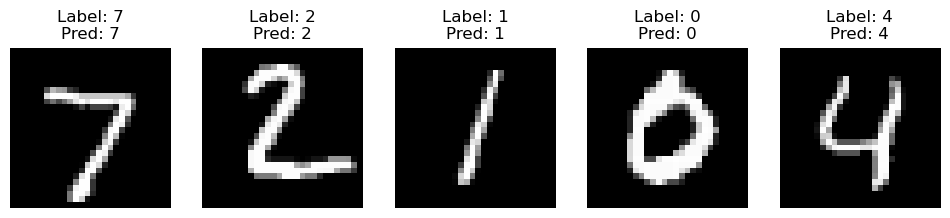

In [8]:
# ========================
# 7. Optuna 스터디 생성 및 최적화 실행
# ========================
if __name__ == "__main__":
    # Optuna 스터디 생성 (목표는 최대화, 즉 정확도 최대화)
    study = optuna.create_study(direction='maximize')
    
    # 최적화 실행 (예: 20번의 시도)
    study.optimize(objective, n_trials=20)
    # objective 함수에서 각 trial마다 모델은 초기화된다. 
    # 하이퍼파라미터 튜닝이 완료된 후, 최적의 하이퍼파라미터를 사용하여 최종 모델을 다시 학습할 때도 모델은 새로 초기화된다.
    
    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print(f"  Accuracy: {trial.value:.2f}%")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    # 최적의 하이퍼파라미터로 다시 모델 학습 및 평가
    best_params = trial.params
    train_loader, test_loader = load_data(best_params['batch_size'])
    best_model = LeNet5(dropout_rate=best_params['dropout_rate']) # 최적화된 dropout_rate 설정 및 모델 초기화 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
    
    # 최적의 에포크 수로 학습
    train_model(best_model, train_loader, criterion, optimizer, best_params['num_epochs'])
    
    # 최종 평가
    final_accuracy = evaluate_model_accuracy(best_model, test_loader)
    print(f"Final Accuracy with Best Params: {final_accuracy:.2f}%")
    
    # 출력 예시
    # Best trial:
    # Accuracy: 98.57%
    # Params: 
    # batch_size: 64
    # dropout_rate: 0.2
    # learning_rate: 0.001
    # num_epochs: 20
    # Final Accuracy with Best Params: 98.43%
    
    # 예측 시각화
    visualize_predictions(best_model, test_loader)